In [52]:
!pip install urlextract
from urlextract import URLExtract
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
data = pd.read_excel('/content/drive/My Drive/Bagidata/Comment Spam.xls', usecols =[1,2])
data.head(10)

,Comment,Class
0,this song is racist,0
1,and how many subscribers compared to her over ...,1
2,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1
3,well done shakira,0
4,:D subscribe to me for daily vines,1
5,"Part 2. Holy Mary, pray for us Holy Mother of ...",1
6,"I really can&#39;t comprehend Miley Cyrus , s...",1
7,Nice song ^_^,0
8,This makes me miss the world cup,0
9,******* Facebook is LAME and so 2004! Check ou...,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


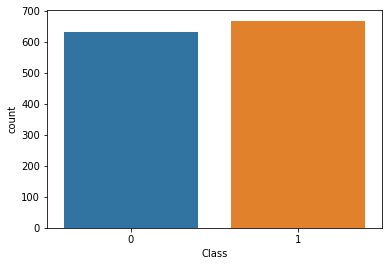

In [54]:
sns.countplot('Class', data=data)

In [55]:
spam_class = data['Class']
spam_class.value_counts()

1    669
0    631
Name: Class, dtype: int64

# Text Preprocessing

In [56]:
# function to extract url and split the path
def split_url(text):
  extractor = URLExtract()
  extract_url = extractor.find_urls(text)
  if len(extract_url) > 0 :
    merge_all = []
    for i in extract_url :
      text = re.sub(i, '', text)
      split_path = i.split("/")
      join_path = ' '.join(split_path)
      merge_all.append(join_path)
    text2 = ' '.join(merge_all)
    return (text + ' ' + text2)
  else :
    return text

def PreProcess(list):
  post_data = []
  stemmer= PorterStemmer()
  stop_words = set(stopwords.words('english'))
  for line in list:
    # Case folding
    data = str(line).lower()
    # split url path
    data = split_url(data)
    # remove number & punctuation
    data = re.sub('[^a-z]+', ' ', data)
    # remove double, triple, and so on space
    data = re.sub('\s+',' ', data)
    tokens = word_tokenize(data)
    stemmer_sentence = []
    for word in tokens:
      # remove stopwords
      if word not in stop_words :
      # stemming
        stemmer_word = stemmer.stem(word)
        stemmer_sentence.append(stemmer_word)
    data = ' '.join(stemmer_sentence)
    # append all 
    post_data.append(data)
  return post_data

In [57]:
post_comment = PreProcess(data['Comment'])

In [ ]:
post_comment[:10]

['song racist',
 'mani subscrib compar million',
 'hi check awesom cover say think',
 'well done shakira',
 'subscrib daili vine',
 'part holi mari pray us holi mother god pray us holi virgin virgin pray us mother christ pray us mother divin grace pray us mother pure pray us mother chast pray us mother inviol pray us mother undefil pray us mother amiabl pray us mother admir pray us mother good counsel pray us mother creator pray us mother redeem pray us',
 'realli comprehend miley cyru actual high profil tape bang today video leech suck fuck video post celebr websit miley celeb news co uk',
 'nice song',
 'make miss world cup',
 'facebook lame check swagfriend com make thousand cool new friend everyday join new movement']

# Convert text into matrix using tf-idf

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5)
X_tf = tfidf.fit_transform(post_comment)
tf = pd.DataFrame(X_tf.toarray(), columns=tfidf.get_feature_names())
print(tf)

      account  actual  adam  adf  ...  youtub need  youtub video  zonepa  zonepa com
0         0.0     0.0   0.0  0.0  ...          0.0           0.0     0.0         0.0
1         0.0     0.0   0.0  0.0  ...          0.0           0.0     0.0         0.0
2         0.0     0.0   0.0  0.0  ...          0.0           0.0     0.0         0.0
3         0.0     0.0   0.0  0.0  ...          0.0           0.0     0.0         0.0
4         0.0     0.0   0.0  0.0  ...          0.0           0.0     0.0         0.0
...       ...     ...   ...  ...  ...          ...           ...     ...         ...
1295      0.0     0.0   0.0  0.0  ...          0.0           0.0     0.0         0.0
1296      0.0     0.0   0.0  0.0  ...          0.0           0.0     0.0         0.0
1297      0.0     0.0   0.0  0.0  ...          0.0           0.0     0.0         0.0
1298      0.0     0.0   0.0  0.0  ...          0.0           0.0     0.0         0.0
1299      0.0     0.0   0.0  0.0  ...          0.0           0.0 

# Logistic Regression

In [ ]:
# Split data without K-fold cross validation
X_train, X_test, y_train, y_test = train_test_split(tf, spam_class, 
                                                    test_size = 0.20, 
                                                    random_state = 60)
# Train our logistic regression 
logreg = LogisticRegression(random_state=10)
logreg.fit(X_train, y_train)
accuracy_train = accuracy_score(y_train, logreg.predict(X_train))
yhat_logreg = logreg.predict(X_test)
clt_test = pd.crosstab(yhat_logreg, y_test,  rownames=['Predicted'], 
                  colnames=['Actual'], margins=True)

print ("Accuracy Training = {:.2f}".format(accuracy_train))
print ("------------------------Testing--------------------------")
print (classification_report(y_test, yhat_logreg))
print("Confusion Matrix: \n",clt_test)

Accuracy Training = 0.97
------------------------Testing--------------------------
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       129
           1       0.97      0.93      0.95       131

    accuracy                           0.95       260
   macro avg       0.95      0.95      0.95       260
weighted avg       0.95      0.95      0.95       260

Confusion Matrix: 
 Actual       0    1  All
Predicted               
0          125    9  134
1            4  122  126
All        129  131  260


In [ ]:
def kfold_cv(n_kfold, X, y, model):
  cv = StratifiedKFold(n_splits=n_kfold, shuffle=False)
  i=1
  for train_idx, test_idx in cv.split(X, y):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    model.fit(X_train, y_train)
    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    yhat = model.predict(X_test)
    clt_test = pd.crosstab(yhat, y_test,  rownames=['Predicted'], 
                  colnames=['Actual'], margins=True)

    print ("------------------FOLD KE = {:.0f}-------------------".format(i))
    i=i+1
    print ("Accuracy Training = {:.2f} ".format(accuracy_train))
    print("Testing: ")
    print (classification_report(y_test, yhat))
    print("Confusion Matrix: \n", clt_test)

In [ ]:
# Split data with 10-fold cross validation to avoid overfit/underfit model
# and to choose best subset for training & testing
logreg = LogisticRegression(random_state=10)
kfold_cv(5, tf.values, spam_class, logreg)

------------------FOLD KE = 1-------------------
Accuracy Training = 0.97 
Testing: 
              precision    recall  f1-score   support

           0       0.79      1.00      0.89       127
           1       1.00      0.75      0.86       133

    accuracy                           0.87       260
   macro avg       0.90      0.88      0.87       260
weighted avg       0.90      0.87      0.87       260

Confusion Matrix: 
 Actual       0    1  All
Predicted               
0          127   33  160
1            0  100  100
All        127  133  260
------------------FOLD KE = 2-------------------
Accuracy Training = 0.96 
Testing: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       126
           1       0.98      0.90      0.94       134

    accuracy                           0.94       260
   macro avg       0.94      0.94      0.94       260
weighted avg       0.94      0.94      0.94       260

Confusion Matrix: 
 Actual     

# Naive Bayes Classification

In [ ]:
nbc = BernoulliNB()
kfold_cv(5, tf.values, spam_class, nbc)

------------------FOLD KE = 1-------------------
Accuracy Training = 0.92 
Testing: 
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       127
           1       1.00      0.74      0.85       133

    accuracy                           0.87       260
   macro avg       0.89      0.87      0.86       260
weighted avg       0.89      0.87      0.86       260

Confusion Matrix: 
 Actual       0    1  All
Predicted               
0          127   35  162
1            0   98   98
All        127  133  260
------------------FOLD KE = 2-------------------
Accuracy Training = 0.90 
Testing: 
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       126
           1       0.98      0.76      0.86       134

    accuracy                           0.87       260
   macro avg       0.89      0.87      0.87       260
weighted avg       0.89      0.87      0.87       260

Confusion Matrix: 
 Actual     

# SVM Classification

In [ ]:
# Tuning the parameter
X_train, X_test, y_train, y_test = train_test_split(tf, spam_class, 
                                                    test_size = 0.20, 
                                                    random_state = 60)
C = [1, 10, 100]
gamma = [0.1, 1, 10, 100]
kernel = ['linear', 'rbf']
probability = [True]
param_grid = {'C':C, 'gamma':gamma, 'kernel':kernel, 'probability':probability}
svc = svm.SVC(random_state=60)
grid_search = GridSearchCV(svc,param_grid=param_grid,cv=5)
grid_search.fit(X_train,y_train)

print("Best Score:" + str(grid_search.best_score_))
print("Best Parameters: " + str(grid_search.best_params_))

Best Score:0.9538461538461538
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}


In [ ]:
# Modeling with the best parameter
best_svc = grid_search.best_estimator_
kfold_cv(5, tf.values, spam_class, best_svc)

------------------FOLD KE = 1-------------------
Accuracy Training = 1.00 
Testing: 
              precision    recall  f1-score   support

           0       0.64      0.98      0.77       127
           1       0.95      0.47      0.63       133

    accuracy                           0.72       260
   macro avg       0.80      0.73      0.70       260
weighted avg       0.80      0.72      0.70       260

Confusion Matrix: 
 Actual       0    1  All
Predicted               
0          124   70  194
1            3   63   66
All        127  133  260
------------------FOLD KE = 2-------------------
Accuracy Training = 0.99 
Testing: 
              precision    recall  f1-score   support

           0       0.67      0.94      0.78       126
           1       0.90      0.56      0.69       134

    accuracy                           0.74       260
   macro avg       0.79      0.75      0.74       260
weighted avg       0.79      0.74      0.73       260

Confusion Matrix: 
 Actual     

# KNN

In [ ]:
# Tuning the parameter
X_train, X_test, y_train, y_test = train_test_split(tf, spam_class, 
                                                    test_size = 0.20, 
                                                    random_state = 60)

param_grid = {'n_neighbors':np.arange(1,10)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn,param_grid,cv=5)
grid_search.fit(X_train,y_train)

print("Best Score:" + str(grid_search.best_score_))
print("Best Parameters: " + str(grid_search.best_params_))

Best Score:0.8163461538461538
Best Parameters: {'n_neighbors': 1}


In [ ]:
# modelling with k=1
knn = KNeighborsClassifier(1)
kfold_cv(5, tf.values, spam_class, knn)

------------------FOLD KE = 1-------------------
Accuracy Training = 1.00 
Testing: 
              precision    recall  f1-score   support

           0       0.64      0.98      0.77       127
           1       0.95      0.47      0.63       133

    accuracy                           0.72       260
   macro avg       0.80      0.73      0.70       260
weighted avg       0.80      0.72      0.70       260

Confusion Matrix: 
 Actual       0    1  All
Predicted               
0          124   70  194
1            3   63   66
All        127  133  260
------------------FOLD KE = 2-------------------
Accuracy Training = 0.99 
Testing: 
              precision    recall  f1-score   support

           0       0.67      0.94      0.78       126
           1       0.90      0.56      0.69       134

    accuracy                           0.74       260
   macro avg       0.79      0.75      0.74       260
weighted avg       0.79      0.74      0.73       260

Confusion Matrix: 
 Actual     